# Ray Tracing

## Grundlagen

Was ist die grundlegende Idee von Raytracing?
Wichtig ist dafür zuerst zu verstehen wie Licht funktioniert.

Ein einfacher Ansatz dafür ist, anzunehmen das Licht aus Strahlen besteht.  
Diese Strahlen werden aus einer Lichtquelle ausgesendet, werden von Objekten reflektiert und absorbiert und zu guter Letzt kommen sie im Beobachters an.  
Der Beobachter wird hier Kamera genannt.

Schematisch und zwei dimensional sieht das so aus:
![][2d_ray_tracing]<!--TODO bild besser einfügen-->

Schritt für Schritt müssen also folgende Dinge geschehen: <!--TODO bessere Formulierung-->

1. Die Lichtquelle sendet einen Lichtstrahl aus
2. Dieser Lichtstrahl trifft auf ein Objekt
3. Das Objekt reflektiert und absorbiert teil des Lichtstrahls
4. Schritt 2 und 3 wiederholen sich bis der Lichtstrahl entweder eine Kamera oder kein Objekt mehr trifft
5. Lichtstrahl trifft auf die Kamera
6. Schritt 1 bis 6 werden wiederholt bis der Nutzer mit dem gerenderten Bild zufrieden ist

Dieser Ansatz ist allerdings sehr ineffizient, da dann viele Lichtstrahlen keine Kamera treffen.
Für eine bessere Optimierung werden die Lichtstrahlen aus der Kamera ausgesendet und der Lichtpfad wird erst nach dem Auftreffen auf die Lichtquelle vollständig berechnet.

<!--TODO bild durch nur kreise ersetzen-->
[2d_ray_tracing]: ./assets/2D_ray_tracing.png


## Lichtstrahlen (Rays)

Ein Lichtstrahl besteht aus Ortsvektor und Richtungsvektor.
Der Ortsvektor gibt dabei den Punkt an, an dem der Lichtstrahl ausgesendet wurde
und der Richtungsvektor die Richtung in die der Strahl gesendet wird.  
Also $\vec{ray(t)}=\vec{O}+\vec{d}*t$

in Python definieren wir einen Ray so:

In [43]:
import numpy as np
import numpy.typing as npt
from typing import NamedTuple, Tuple

Vec = npt.NDArray[np.float64]

class Ray(NamedTuple):
    location: Vec
    direction: Vec


Typischerweise ist der Richtungsvektor normiert, dafür dient diese Funktion

In [44]:
def normalizeVector(vec: Vec):
    return vec/np.linalg.norm(vec)

## Aussenden eines Lichtstrahls

Die Kamera sendet Lichtstrahlen aus.
Die Kamera ist modelliert als eine Lochkamera. Es gibt einen Sensor, auf dem alle Pixel liegen. Der Sensor ist eine Fläche.
Alle Lichtstrahlen werden von den Pixeln des Sensors über einen Punkt, die Blende, ausgesendet.

<!--Bild updaten-->
![](./assets/kamera.png)


In [45]:
class ImageSize(NamedTuple):
    width: int
    height: int

class Camera:
    def __init__(self, imageSize: ImageSize) -> None:
        assert 0 < imageSize.width and 0 < imageSize.height, f"image cant have negative Dimestions, was {imageSize}"
        self.imageSize = imageSize
        self.unitPerPixel = np.sqrt(self.imageSize.width ** 2 + self.imageSize.height ** 2)
        self.sensorPosition = np.array([1,0,0])
        self.aperturePosition = np.array([0,0,0])
    
    def _getRay(self, pixelX:int,pixelY:int)->Ray:
        assert 0 <= pixelX < self.imageSize.width, f"pixelX has to be in Image, was {pixelX}" 
        assert 0 <= pixelY < self.imageSize.height, f"pixelY has to be in Image, was {pixelY}"
        x = -self.imageSize.width/2 + pixelX
        y = -self.imageSize.height/2 + pixelY
        pixelPos = self.sensorPosition + np.array([0, x/self.unitPerPixel, y/self.unitPerPixel])
        rayDirection = normalizeVector(pixelPos - self.aperturePosition)
        return Ray(self.aperturePosition, rayDirection)

camera = Camera(ImageSize(128, 128))
camera._getRay(50,50)

Ray(location=array([0, 0, 0]), direction=array([ 0.99407169, -0.07688131, -0.07688131]))


## Schnittpunkt eines Lichtstrahls mit einem Objekt

Nachdem der Lichtstrahl ausgesendet wurde, muss der erste Auftreffpunkt des Lichtstrahls auf einem Objekt berechnet werden.
Hier werden zur Vereinfachung nur Kreise als Objekte genutzt. 
Schnittpunkte sind dabei alle Punkte, die genau den Radius $r$ des Kreises von dessen Mittelpunkt $C$ entfernt sind.
also:

$$
||\vec{P}-\vec{C}||=r
$$

Für die Lichtstrahlen gilt damit

$$
||\vec{ray(t)}-\vec{C}||=r
$$
$$
||\vec{O}+\vec{d}*t-\vec{C}|| = r
$$

umgeformt ergibt das eine Quadratische Gleichung:

$$
||\vec{d}||^2*t^2+2t*<\vec{d},\vec{O}-\vec{C}>+<\vec{O}-\vec{C},\vec{O}-\vec{C}>-r^2=0
$$

um die Schnittpunkte heruaszufinden, muss die Gleichung nacht $t$ aufgelöst werden. 
Das wird hier in code umgesetzt.

In [56]:
from abc import ABC, abstractmethod 

class Object:
    @abstractmethod
    def hit(self, ray: Ray) -> npt.NDArray[np.float64]:
        pass

class Circle(Object):
    def __init__(self, center: Vec, radius: float) -> None:
        self.center = center
        self.radius = radius
        super().__init__()

    def hit(self, ray: Ray) -> npt.NDArray[np.float64]:
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            return [t1,t2]
        return []
    

ray = Ray(np.array([0,0,0]),np.array([1,0,0]))
circle: Object = Circle(np.array([5,0,0]),1)

circle.hit(ray)

[6.0, 4.0]

Diese Berechnung muss nun für alle Objekte gemacht werden. Dabei ergeben sich voraussichtlich mehrere Werte für $t$.
Der Auftreffpunkt des Lichtstrahls ist der Punkt, für den $t$ minimal aber größer Null ist. 

## Erster Test

Nun kann alles ein erstes Mal getestet werden.
<!--TODO text hier-->

ImageSize(width=256, height=512)


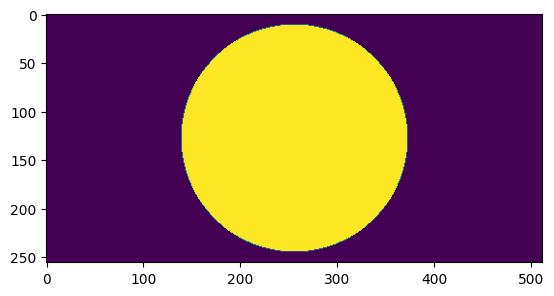

In [65]:
import matplotlib.pyplot as plt

camera = Camera(ImageSize(256, 512))
circle: Object = Circle(np.array([5, 0, 0]), 1)

img = np.zeros(camera.imageSize)

for x in range(camera.imageSize.width):
    for y in range(camera.imageSize.height):
        ray = camera._getRay(x,y)
        hits = circle.hit(ray)
        if len(hits)>0:
            img[x,y] = 1

plt.imshow(img)


## Lichtstrahl Reflexion/Absorption

## Lichtstrahl in Kamera